# 1. 剧情回顾

在上一个[notebook](https://github.com/rikichou/yolo/blob/master/YOLO_face_detection_and_recognition_1--first_sight_of_darknet.ipynb)中，我简要介绍了darknet，它是一个使用C语言实现的深度学习框架，里面提供了YOLO模型的配置文件以及预训练权重，我们可以轻易地通过几行命令就能够实现目标检测。但是假如我们想用自己的数据搭建一个YOLO目标检测模型的话，改怎么做呢？也就是说，我们要利用darknet在我们自己提供的数据上，对YOLO模型进行训练，改怎么做？其实，[darknet](https://pjreddie.com/darknet/yolov2/)官网已经提供了相应的例子来说明如何训练

× 注意：我所说的YOLO其实是YOLOV2

# 2.VOC数据集

严格地说应该叫[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)数据集，该数据集是一个用于构建图片分类，目标检测，图片分割的数据集。2005--2012年，每年都会举办Pascal VOC挑战赛，在2012年，由于VOC项目的重要成员Mark Everingham去世，所以该比赛就停止了。

该数据集包含了用于目标检测的图片数据以及相应的annotations信息，其中该数据集包含20个类别检测对象。我们将利用2007年和2012年的数据集对YOLO模型进行重新训练。

darknet官网很人性化地提供了VOC数据集的[下载链接](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)，首先进入darknet目录，然后通过以下命令可以直接下载数据集并解压到当前目录：

    wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
    wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
    
    tar xf VOCtrainval_11-May-2012.tar
    tar xf VOCtrainval_06-Nov-2007.tar
    tar xf VOCtest_06-Nov-2007.tar

说明：首先建议用迅雷下载，用wget或者自带浏览器下载比较慢。另外，如果你是在云服务器上进行训练的话，那就只能用wget下载了，此时不建议在darknet网站下载此数据，建议直接在Pascal VOC的比赛官网下载2007和2012的对应的那三个文件，速度很快。

## 2.1 了解数据

数据集解压之后，数据的结构大概如下：

--|VOCdevkit  
--|-----VOC2007  
--|----------Annotations  
--|----------ImageSets  
--|---------------Main  
--|----------JPEGImages  
--|----------SegmentationClass  
--|----------SegmentationObject  
--|-----VOC2012  
--|----- .  
--|----- .  
--|----- .  

VOC2007和VOC2012就是我们解压的两个之后的数据集文件夹，他们两个的目录结构完全一致。接下来我们来说说我们需要了解的文件。

Annotations文件夹包含了M个xml文件，M表示图片的数量。这些xml文件里面包含了图片的基本信息，比如图片的大小，以及图片中包含的目标，目标的bounding box，目标的类别等等信息，这些信息在我们训练的时候需要用到。

ImageSets文件夹里面我们只关心Main文件夹，Main文件夹里面都是txt文件，每个txt文件都包含了对应的数据集中每个图片的ID。比如train.txt文件中包含了训练集的图片的ID。

JPEGImages文件夹里面包含了我们真正的图片数据

剩下的两个文件夹是关于图片分割的内容，我们也不关心

# 3 训练

了解了数据之后我们就可以开始按照官网上的教程进行训练流程了。开始训练之前，还需要做一件事情就是训练数据的标签提取

## 3.1 label提取

因为我们是使用darknet来训练YOLO，所以我们需要将数据集的label转换为darknet希望的形式。darknet希望为每一张图片都建立一个对应的txt文件来表示一张图片的信息，该信息的格式如何：

    <object-class> <x> <y> <width> <height>
    
object-class为对象的类别，voc数据集可能有多个类别。  
x为对象（bounding box）的中心点横坐标  
y为对象（bounding box）的中心店的纵坐标  
width为对象（bounding box）的宽度
hight为对象（bounding box）的高度  

其中在TXT文件中，每一行代表一个bounding box的信息，如果一张图片有多个对象，那么对应地就会有多行类似上面的数据

注意：以上的计算都是以图片左上角为坐标原点(0, 0)，图片右下角为坐标(1, 1)，所以以上的取值都在[0,  1]之间

那么清楚了格式之后如何来提取呢？其实，darknet早就帮我我们写好了提取label的脚本了，我已我们只需要下载脚本，运行脚本就好了。

wget https://pjreddie.com/media/files/voc_label.py

python voc_label.py

运行结束之后，在darknet目录下生成了多个TXT文件(2007_train.txt 2007_test.txt 2007_val.txt 2012_train.txt 2012_val.txt)，这些TXT文件包含了对应数据集的中每张图片的绝对路径。

另外，我们会发现在我们每个数据集的目录下（比如darknet/VOCdevkit/VOC2007/labels）多了一个labels文件夹，改文件夹里面包含了许多TXT文件，这些TXT文件就是我们需要的每张图片的label信息。

紧接着，因为我们要将2007_train.txt 2007_val.txt 2012_train.txt 2012_val.txt等文件中表示的图片作为训练集了训练YOLO模型，所以我们把这些TXT文件合并成一个大的TXT文件传输给darknet

cat 2007_train.txt 2007_val.txt 2012_*.txt > train.txt

## 3.2 建立配置文件

在使用darknet训练YOLO模型的时候，我们需要建立配置文件来告诉darknet数据集的信息。这些信息包括

1， 该数据集一共含有多少类对象  
2， 该数据集每一类对象的名字  
3， 包含训练集图片的绝对路径的TXT文件在哪儿  
4， 包含验证集图片的绝对路径的TXT文件在哪儿

darknet已经有了该配置文件cfg/voc.data，我们只需要做适当的修改就好了。

classes= 20  
train  = train.txt  
valid  = 2007_test.txt  
names = data/voc.names  
backup = backup  

因为我的TXT文件都生成在了darknet的目录里面，所以直接写相对路径就好了

## 3.3 下载预训练权重

YOLOV2的论文中，在对YOLO的目标检测模型进行训练之前，将YOLO作为分类模型在ImagNet数据集上进行了预训练，训练的具体参数在这里不提，感兴趣的可以去看看论文。

为什么要这样做呢？我们知道图片数据的基本结构都是很相似的，都是由一些边缘组成基本形状然后再组成抽象的物体，也就是说对于图片的很多特征，特别是底层的特征，我们是可以共享的。既然如此，我就可以先让YOLO在大数据集（imagenet）中学习到一些通用的“知识”（表现为卷积层权重），然后再将这些“知识”作为训练目标检测模型的初始权重，那么这样就可以以这些“知识”为基础进行学习，大大提升了学习的效率，这就是我们所说的迁移学习！

所以我们可以将YOLO模型作为分类模型在imagenet上的1000类的庞大数据集中进行与训练，然后再将这些权重作为初始权重来进行目标检测的学习。当然，我肯定不会去做这个预训练的步骤，感兴趣的朋友可以去论文中获取具体训练的细节。

darknet支持支持在训练的时候载入预训练权重，所以我们只需要下载该权重即可，darknet提供了该权重的下载

wget https://pjreddie.com/media/files/darknet19_448.conv.23

## 3.4 修改要训练的YOLOV2模型的配置文件

之前在3.2节中我们修改的是关于数据的配置文件，现在我们需要修改的是模型的配置文件，我们使用的模型是yolov2，所以对应地在cfg/yolov2-voc.cfg文件中就包含了该模型的配置信息以及训练该模型的参数信息，这里我们仅仅需要修改一个batch size参数就好了。

这里我们将cfg/yolov2-voc.cfg文件中前几行改为如下形式就好了

    [net]
    # Testing
    # batch=1
    # subdivisions=1
    # Training
    batch=64
    subdivisions=8

注意官网并没有提及3.4这一步，如果没有进行这一步，那么我们的样本训练的batch size将会是1，这个batch size是在预测的时候使用的，这样在训练了大约6000张图片后，你就会发现你的IOU和其他一些训练的调试信息将会变成NaN,就是这个参数造成的。

## 3.5 训练

现在一切准备就绪，可以开始训练了，其实训练就一句话

./darknet detector train cfg/voc.data cfg/yolov2-voc.cfg darknet19_448.conv.23

    train:代表我们现在进行的是训练
    cfg/voc.data：是本次训练的配置文件
    cfg/yolov2-voc.cfg：这是YOLOV2模型的配置文件
    darknet19_448.conv.23：这是YOLO模型的预训练权重

在这里我声明一下，我开始训练的时候使用的是我自己的主机上进行训练的，我的机器配置是GTX 960 GPU，2GB显存，不出意外地，训练过程中，直接报了类似“out of memory”之类的信息，即使把batch size调整到16，训练大概不到300个batch的时候也会报错，所以我直接放弃在本地训练该项目的想法。

这里我推荐一个[亚马逊EC2云服务器](https://amazonaws-china.com/cn/ec2/?hp=tile&so-exp=below)，可以在上面租用云服务器进行模型的训练，价格相对国内的阿里云或者腾讯云更便宜。只不过你需要准备一张普通信用卡，而且用完了服务器之后一定要关闭，具体的细节在这里就不介绍了，感兴趣的可以看此[教程](https://zhuanlan.zhihu.com/p/33173963?utm_source=wechat_session&utm_medium=social)。EC2的缺点就是使用和申请提升实例限制比较繁琐，如果嫌麻烦的同学可以试试阿里云或者腾讯云，比EC2方便！

这里我使用的是EC2中的p2.xlarge云服务器，GPU为Tesla K80，12GB显存，足够应付本次训练。

在训练的过程中，要注意观察输出的打印信息，如果发现很多参数都是nan的话那就可能是你的模型配置文件没有配置好，比如batch size不对，或者learning rate过高（这是在使用自己的数据集进行训练的情况下，一般voc数据集就使用默认的配置就好，但是也要执行3.4步的修改才行）

# 4 人脸检测模型的训练



好像到目前为止，我们的操作有点儿偏题了，不是说好了在人脸数据上进行训练么？其实刚才只是为了让我们更熟悉使用darknet进行训练的流程，现在我们就选择一个人脸数据集进行训练。我们选择的是著名的人脸检测数据集：[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

## 4.1 更改模型配置文件



虽然我们依旧使用YOLOV2的模型进行训练，但是现在任务以及数据集确改变了，此时我们不再检测VOC数据集的20个类别的目标，我们只检测1个类别：是否是人脸，所以现在需要对yolov2-voc.cfg文件进行修改，这里我们拷贝yolov2-voc.cfg为yolov2-celeba.cfg，下面对yolov2-celeba.cfg进行修改

    1.batch=64 subdivisions=8

    2.classes=20改为classes=1

    3.将237行的filters=125改为filters=30，30是这样算出来的(类别数量 + 5) * anchor数量 = 30，其中5代表的是xywh坐标以及class类标签

另外，在配置[region]里面的anchors参数表示anchors大小，这个和具体的数据集相关，因为我们训练的数据集是CelebA,所以不能够使用VOC的anchors，我们需要在CelebA数据集上使用k-means聚类算法来得出anchors的大小。具体的做法在4.3.5中。

## 4.2 创建类别名称文件

之前我们的voc.names里面包含了每一类别对象的名称，虽然现在只有一个类别，但是也应该指定名称，我们现在再data目录下创建一个celeba.names，里面只有一行内容，就是face。

## 4.3 创建数据集相关的文件

在3.1节中，我们利用voc_label.py这个脚本创建了关于数据集路径的TXT文件，而且还为每张图片创建了关于图片对象的bounding box信息的TXT文件。但是这里我们使用不同的数据集，这个脚本就用不上了，我们需要自己写程序来完成类似的功能。

### 4.3.1 了解数据集

在做上述的这一切之前，让我们来了解了解我们将要使用的数据集。

[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)是一个大规模人脸属性数据集，其拥有超过20W张名人的图像（貌似没看到亚洲人？），每张图片拥有40个属性标注，比如是否戴眼镜，是否微笑，是否戴帽子等等，当然还有我们需要的bounding box的标注。该数据集中的图像中的人物摆出了不同角度的姿势，并且图像拥有 复杂的背景。更准确地，该数据集拥有10177个名人的202599张脸部图像，每张图像拥有5个脸部位置标记以及40个二值属性。

官网的下载链接已经无法使用了，但是官网给出了另外两个下载链接，一个是[百度云盘](https://pan.baidu.com/s/1eSNpdRG#list/path=%2F)，一个是[谷歌云盘](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8)，我是从百度云盘下载的，不知道什么原因，谷歌云盘的下载下来的文件丢失了许多！

在文件下载下来了以后，我们会发现文件呈现如下的结构：

|----CelebA  
|　　｜----Img  
|　　｜　　｜----img_celeba.7z  
|　　｜----Eval  
|　　｜　　｜----list_eval_partition.txt  
|　　｜----Anno  
|　　｜　　｜----list_bbox_celeba.txt  


其中Img目录为存放图片的目录，里面包含了三个文件。第一个文件夹是img_celeba.7z，里面是原始的训练集图片，这就是我们做人脸检测的数据集。第二个文件是img_align_celeba.zip，从名字可以看出，这里面包含了在原始图片上进行裁剪的图片，只有一个大头，这种数据适合用于做人脸识别。第三个文件夹是img_align_celeba，这个文件夹里面的图片其实和第二个文件里的一样，只不过这个文件夹里的图片格式是png，更清晰！所以这里我们只关心img_celeba.7z文件夹，请自行将其解压缩。

在Eval中，list_eval_partition.txt文件已经为我们划分好了0--训练集，1--验证集，2--测试集

在Anno中，list_bbox_celeba.txt文件包含了每一张图片的bounding box，该bounding box的表示方法是box左上角的坐标x,y以及该box的宽度高度w,h。

由于我们并不需要所有的数据，所以我现在要将刚才解压出来的部分数据拷贝出来用于darknet的训练。（我假装你就是在darknet目录下加压出CelebA的）

假设当前目录是darknet目录，我们创建一个celeba目录，并且仿造VOC目录结构，在celeba目录下创建一个labels目录和JPEGImages目录，现在要做的就是将所有位于./darknet/CelebA/Img/img_celeba中的图片拷贝（我使用的软链接，节约空间）到./darknet/celeba/JPEGImages目录下。那么此时我们的darknet的目录结构大概如下：

|----darknet  
|　　｜----CelebA  
|　　｜　　｜----Img  
|　　｜　　｜----Eval  
|　　｜　　｜----Anno  
|　　｜----celeba  
|　　｜　　｜----JPEGImages   
|　　｜　　｜----labels  
|----yolo  
|　　｜----YOLO_face_detection_and_recognition_2--train_yolo_on_CelebA_datasheet.ipynb  

我们待会儿在4.4节会解释为什么需要将我们的数据存放在celeba目录中。

(有必要说明一下，本notebook文件存放的目录就是上图中的yolo目录下)

In [1]:
import os
import shutil

proj_dir = os.path.dirname(os.getcwd())
darknet_dir =  proj_dir + "/darknet"
bbox_path = darknet_dir + '/celeba/list_bbox_celeba.txt'
eval_path = darknet_dir + '/celeba/list_eval_partition.txt'

if not os.path.isdir(darknet_dir+"/celeba"):
    
    print ("Now to create data dir to compatible with darknet")
    
    os.makedirs(darknet_dir+"/celeba/JPEGImages")
    os.makedirs(darknet_dir+"/celeba/labels")
    
    ## copy the txt file
    shutil.copyfile(darknet_dir+"/CelebA/Anno/list_bbox_celeba.txt",bbox_path)
    shutil.copyfile(darknet_dir+"/CelebA/Eval/list_eval_partition.txt",bbox_path)
    
    ## create link from source image data
    filenames = os.listdir(darknet_dir+"/CelebA/Img/img_celeba.7z/img_celeba")
    
    for name in filenames:
        os.symlink(darknet_dir+"/CelebA/Img/img_celeba.7z/img_celeba/"+name, darknet_dir+"/celeba/JPEGImages/"+name)

### 4.3.2 可视化

下面来简单地可视化一下，了解了解我们的数据是什么样子的。

126 22 130 180


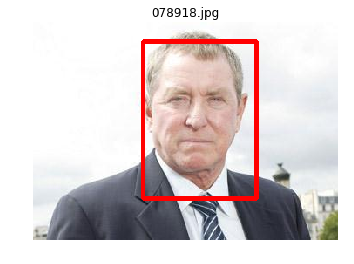

In [33]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline


## read bounding box
img_bbox = {}
with open(darknet_dir+"/CelebA/Anno/list_bbox_celeba.txt") as f:
    lines = f.readlines()
    lines=lines[2:]
    
    line = lines[np.random.randint(len(lines))].strip().split()
    
    img_bbox["name"] = line[0]
    img_bbox["x"] = int(line[1])
    img_bbox["y"] = int(line[2])
    img_bbox["w"] = int(line[3])
    img_bbox["h"] = int(line[4])
    
## read image
img_path = darknet_dir+"/CelebA/Img/img_celeba.7z/img_celeba/" + img_bbox["name"]
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
(img_h, img_2) = img.shape[0:2]

print (img_bbox["x"], img_bbox["y"], img_bbox["w"], img_bbox["h"])
## display
cv2.rectangle(img,(img_bbox["x"],img_bbox["y"]),(img_bbox["x"]+img_bbox["w"],img_bbox["y"]+img_bbox["h"]),(255,0,0),3)

plt.imshow(img)
plt.axis("off")
plt.title(img_bbox["name"])
plt.show()

### 4.3.3 训练集测试集验证集划分

其实就是生成train.txt  val.txt  test.txt,根据前面的描述，list_eval_partition.txt这个文件中已经分配好了这些，0代表训练集，1代表验证集，2代表测试集。

In [3]:
train_txt = darknet_dir + '/celeba/train.txt'
val_txt = darknet_dir + '/celeba/val.txt'
test_txt = darknet_dir + '/celeba/test.txt'

train_p = open(train_txt, "w")
val_p = open(val_txt, "w")
test_p = open(test_txt, "w")

with open(eval_path) as p:
    lines = p.readlines()
    t = 0
    v = 0
    e = 0
    for line in lines:
        items = line.strip().split()
        img_path = darknet_dir+"/celeba/JPEGImages/" + items[0] + '\n'
        img_type = int(items[1])
        
        if img_type == 0:
            train_p.write(img_path)
            t += 1
        elif img_type == 1:
            val_p.write(img_path)
            v += 1
        else:
            test_p.write(img_path)
            e += 1
    print ("train {}, validation {}, test {}".format(t, v, e))

train_p.close()
val_p.close()
test_p.close()

train 162770, validation 19867, test 19962


### 4.3.4 生成每张图片对应的label

darknet需要为每一张图片都建立一个txt文件，该文件描述了该张图片的bounding box的情况以及类别（我们只有一类，所以为0就好），这里我们来创建这些txt文件，并将其放入labels文件夹。

In [4]:
labels_dir = darknet_dir+"/celeba/labels"

def get_w_h(img_name):
    img_path = darknet_dir+"/celeba/JPEGImages/" + img_name
    img = cv2.imread(img_path)
    shape = img.shape
    return shape[1], shape[0]

if not os.listdir(labels_dir):
    with open(bbox_path) as f:
        lines = f.readlines()
        lines = lines[2:]

        for line in lines:
            items = line.strip().split()

            img_name = items[0]
            txt_name = img_name[:-3]+'txt'

            with open(labels_dir+'/'+txt_name, "w") as tf:
                x = int(items[1])
                y = int(items[2])
                w = int(items[3])
                h = int(items[4])

                (width, hight) = get_w_h(img_name)

                txt = "0 " + str((x + w/2.0)/width) + " " + str((y + h/2.0)/hight) + " " + str(w/width) + " " + str(h/hight) + '\n'

                tf.write(txt)

### 4.3.5 对CelebA数据集进行k-means聚类生成anchors

cfg/yolov2-voc.cfg里面配置的anchors参数是根据VOC数据集生成的，但是我们现在使用的CelebA数据集，其anchors形状和VOC数据集有很大的差别，所以我们应该按照论文上说的，利用k-means算法来对CelebA数据集的bounding box进行聚类。

    1，我们只对宽度和高度进行聚类
    2，聚类的宽度和高度是labels/xxxx.txt里面的w和h
    3，聚类的距离衡量为1 - IOU(box1, box2)
    
如果你了解k-means聚类算法的话，那有了上面的信息之后，就很容易实现了。这里我们的实现代码在get_anchors.py中，代码的实现参考了[git](https://github.com/PaulChongPeng/darknet/blob/master/tools/k_means_yolo.py)

在运行下面的代码之前，你需要修改一下你的jupyter notebook配置文件，jupyter_notebook_config.py中的

    c.NotebookApp.iopub_data_rate_limit = 1000000000
    
然后重启jupyter notebook，否则该函数无法执行的，会提示类似"IOPub data rate exceeded."的信息

In [6]:
from get_anchors import compute_centroids

"""
    label_path: include images path
    n_anchors:anchors num
    loss_convergence:stop iteration when loss < loss_convergence
    grid_size:model ouput grid size
    iterations_num:maximun iteration num
    plus:whether using k-mean++
"""
compute_centroids(label_path=train_txt, n_anchors=5, loss_convergence=1e-6, grid_size=13, iterations_num=100, plus=0)

loss = 39788.821759
3.4637721446716245 3.8679346530561665
8.73415659151635 9.022065399147223
6.080188536894121 6.1480227353803745
4.113842273132601 7.792872622416254
6.541522141266076 9.179386902279992
loss = 38953.808750
3.2991065539304754 3.6954213634430886
8.817109040110527 9.154323420550664
5.9872014994098 5.960682669134325
4.066274321258748 7.387195653325293
6.541282130373468 8.873798334661695
loss = 38360.082647
3.197700913252084 3.5745494419106625
8.891012008313446 9.29318822282795
5.868528600057385 5.779226694603637
4.032055267547126 7.073906605696756
6.631827973657741 8.499592481977592
loss = 37600.301370
3.122558972868223 3.4862240427194626
8.976969534524468 9.496612084232558
5.710369065963328 5.6068033967222695
3.9789272162129485 6.88188984886138
6.748434007214307 8.165315914741074
loss = 36804.825333
3.05961210890652 3.419794911354539
9.025794540804332 9.676253227083276
5.558136055981524 5.460715753207885
3.923483211792653 6.817783675220201
6.8102861448801955 7.957062648482

loss = 35327.813976
2.787484540277099 3.2935793774066107
8.36248978076916 9.45570296672632
4.734864241392878 4.777852282236217
4.093138297460683 7.725834044261242
6.5214548888766695 6.786420975193014
loss = 35327.750527
2.7869930746829477 3.293332335529356
8.362305212371655 9.455169595586172
4.734233218093106 4.777248404620133
4.093138297460683 7.725834044261242
6.521020231216437 6.785985807378822
loss = 35328.212875
2.7866418032752738 3.2930224416501384
8.362105562701284 9.454923456642689
4.733499968778213 4.776679652050687
4.093138297460683 7.725834044261242
6.52063816866452 6.785417450941143
loss = 35328.510257
2.7865568745564953 3.292849891827666
8.36181716787083 9.454575872160273
4.7330693609903705 4.77647194727314
4.093018056303678 7.72580526477201
6.520365541444134 6.7848619446726675
loss = 35328.349812
2.786411867325823 3.2927461688577755
8.361623662463577 9.453914848666454
4.732800427981239 4.776333954205533
4.093107793387856 7.726001677786344
6.520004924326265 6.7845007985106

现在咱们就把cfg/yolov2-celeba.cfg的anchors参数改为上面输出的5对值。


    anchors = 2.78625 3.29271 8.36142 9.45355 4.73254 4.77603 4.09317 7.72644 6.51961 6.78404

## 4.4 创建数据集配置文件

接下来我们要模型voc数据集的配置文件cfg/voc.data来创建一个我们自己的数据集配置文件cfg/celeba.data。

    classes= 1
    train  = celeba/train.txt
    valid  = celeba/val.txt
    names = data/celeba.names
    backup = backup
    
我们在4.3.1节中留了一个问题，就是为什么需要那样来建立存放数据集的文件夹？这里来解释一下。

我们知道，在训练的时候，我会把cfg/celeba.data文件以参数的形式传递给darknet，这样darknet才知道训练集和验证集的文件在哪里。但是又一个问题，我们并没有告诉darknet labels文件夹在哪个路径，darknet是怎么找到一张图片相应labels文件呢？

其实，我也是看了源码才知道的，在darknet源码的data.c的220行，有这样一个函数调用

    find_replace(labelpath, "JPEGImages", "labels", labelpath);

然后接着又有一个这样的函数调用

    find_replace(labelpath, ".jpg", ".txt", labelpath);

其实这两个函数就是在利用图片的路径来得到图片对应的labels文件的路径，怎么做的呢？加入图片路径labelpath = "darknet/celeba/JPEGImages/000001.jpg",那么第一个函数调用就是将labelpath路径里面的"JPEGImages"字符串替换为"labels"字符串，那么此时labelpath就变成了"darknet/celeba/labels/000001.jpg"。紧接着第二个函数调用将labelpath路径里面的".jpg"替换为".txt"字符串，此时labelpath就变成了"darknet/celeba/labels/000001.txt"，这不就是000001.jpg图片对应的label文件么。

所以darknet就是这样来得到label的txt文件的，所以我们需要做的就是在JPEGImages文件夹里面放图片，在labels文件夹里面放bounding box信息，而且JPEGImages和labels文件夹要处于同一目录下，这样darknet就可以找到所有它需要的东西了

## 4.5 开始训练

废话不多说，直接运行脚本

./darknet detector train cfg/celeba.data cfg/yolov2-celeba.cfg darknet19_448.conv.23

这里我推荐一个[教程](https://github.com/AlexeyAB/darknet/tree/47c7af1cea5bbdedf1184963355e6418cb8b1b4f#how-to-train-pascal-voc-data)，这个教程介绍了如何训练YOLO，以及什么时候结束训练，介绍得非常好。